In [1]:
from pinatapy import PinataPy
import json

with open('../api_key.json', 'r') as api:
    keys=api.read()
    data = json.loads(keys)
    api_key=data['api_key']
    secret_key=data['secret_key']
pinata = PinataPy(api_key, secret_key)

In [2]:
# The code below is used for pin file from local to IPFS 

# pinata.pin_file_to_ipfs(
#     path_to_file= '../Server/fl_sessions/Session-1671090008/global_session_1671090008_model.npy',
#     ipfs_destination_path = '',
#     save_absolute_paths = False,
#     )
                    

# Build model with model_architecture.json

In [3]:
import tensorflow as tf

with open('../Server/model_architecture.json','r') as file:
    json_data = file.read()
model_architecture = json.loads(json_data)
model = tf.keras.models.model_from_json(model_architecture)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

## Load latest weights from IPFS
Get the latest CID in IPFS

In [4]:
list_files = pinata.pin_list()

In [5]:
latest_CID = list_files['rows'][0]['ipfs_pin_hash']
print(latest_CID)
URL = 'https://gateway.pinata.cloud/ipfs/'+latest_CID
print(URL)

QmQrJChY9yGAtbMCgw7gHCLTBZAGAUHyLqgPNQwMp4qKC1
https://gateway.pinata.cloud/ipfs/QmQrJChY9yGAtbMCgw7gHCLTBZAGAUHyLqgPNQwMp4qKC1


Download latest Parameters.npy and converse it to model weights

In [6]:
import requests
import os
r = requests.get(URL,allow_redirects=True)
if not os.path.exists('./temp'):
    os.mkdir('./temp')
open('./temp/lastParameters.npy', 'wb').write(r.content)

832345

In [7]:
import flwr as fl 
import numpy as np
latest_parameters = np.load('./temp/lastParameters.npy',allow_pickle=True)
latest_weights = fl.common.parameters_to_ndarrays(latest_parameters[0])
# print(latest_weights[0])

Set latest weights

In [8]:
model.set_weights(latest_weights)

## Run prediction and plot confussion matrix


In [9]:
(_,_),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()
y_test = y_test.reshape(-1)
x_test = x_test/255.
predictions = model.predict(x_test)

313/313 [==============================] - 5s 3ms/step


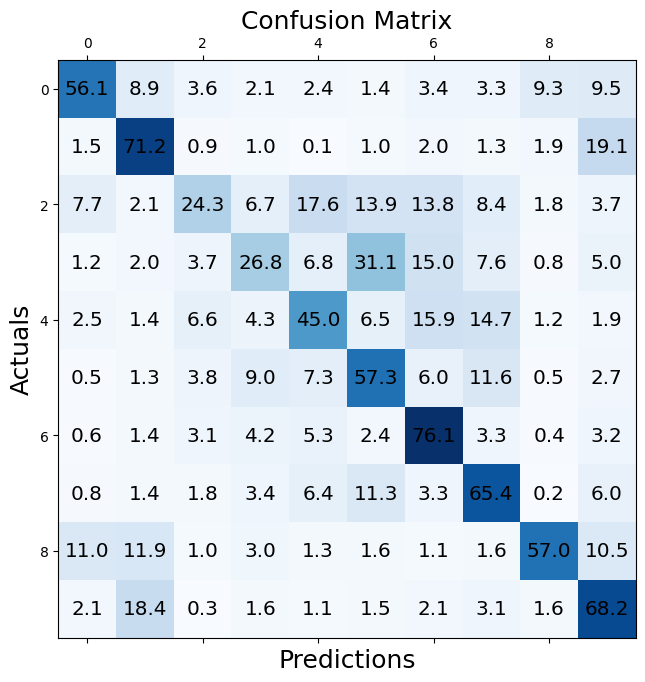

In [10]:
import matplotlib.pyplot as plt
model_preds = predictions.argmax(axis=1)

confusion  = tf.math.confusion_matrix(
    labels=y_test,
    predictions=model_preds,
    num_classes=10    
)
conf_matrix = np.array(confusion)
# print(conf_matrix)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha = 1)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j]/10, va='center', ha='center', size='x-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()        
plt.show()